In [1]:
import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import torch
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import utils
device = "cuda" if torch.cuda.is_available() else "cpu"

# **TP3: Reconnaissance de signaux de communication par apprentissage profond**

## **Auteur**: Naïl Khelifa

## Problématique 

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur 
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie 
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié. 

L'émetteur peut provenir de 6 catégories différentes. 
Les paramètres différenciant les différentes catégories sont 
- le type de modulation 
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données 
- le débit de la transmission 

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0. 


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation 
électromagnétique comme : 
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données). 
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont: 

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet. 
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones". 

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy 

Le TP est composé de trois jeux de données : 
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones 
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [2]:
data_path = '/Users/badis/MVA_deep_and_signal/TP3/samples.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [3]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

## **Visualisation des données**

Commencez par étudier les données: 

    - observez leur taille 
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement 
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez 

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering 

200
Counter({1: 36, 2: 35, 4: 34, 0: 34, 3: 32, 5: 29})
Counter({10: 80, 30: 60, 20: 40, 0: 20})
2


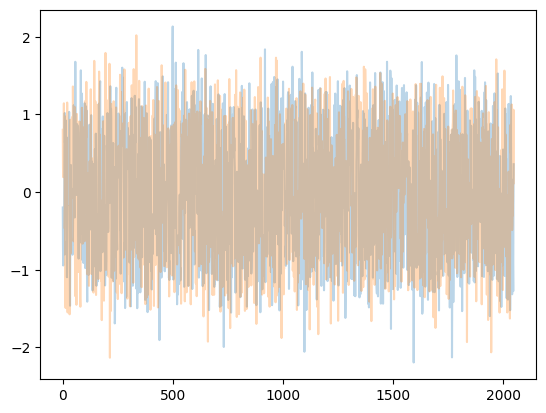

In [4]:
print(len(signals))
print(Counter(labels_id))
print(Counter(snr))

print(labels_id[0])
plt.plot(signals[0], alpha=0.3)
plt.show()

In [ ]:
utils.statistiques_par_classe(signals, labels_id)

Classe 0 - Moyenne: -0.00, Max: 4.96, Min: -4.93, Écart-type: 0.85, Nombre d'échantillons: 34
Classe 1 - Moyenne: 0.00, Max: 4.00, Min: -4.51, Écart-type: 0.79, Nombre d'échantillons: 36
Classe 2 - Moyenne: -0.00, Max: 4.73, Min: -4.74, Écart-type: 0.82, Nombre d'échantillons: 35
Classe 3 - Moyenne: -0.00, Max: 4.98, Min: -5.68, Écart-type: 0.70, Nombre d'échantillons: 32
Classe 4 - Moyenne: 0.00, Max: 4.82, Min: -4.96, Écart-type: 0.70, Nombre d'échantillons: 34
Classe 5 - Moyenne: 0.00, Max: 5.21, Min: -6.53, Écart-type: 0.74, Nombre d'échantillons: 29


/Users/badis/MVA_deep_and_signal/TP3/utils.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", fontsize='small')


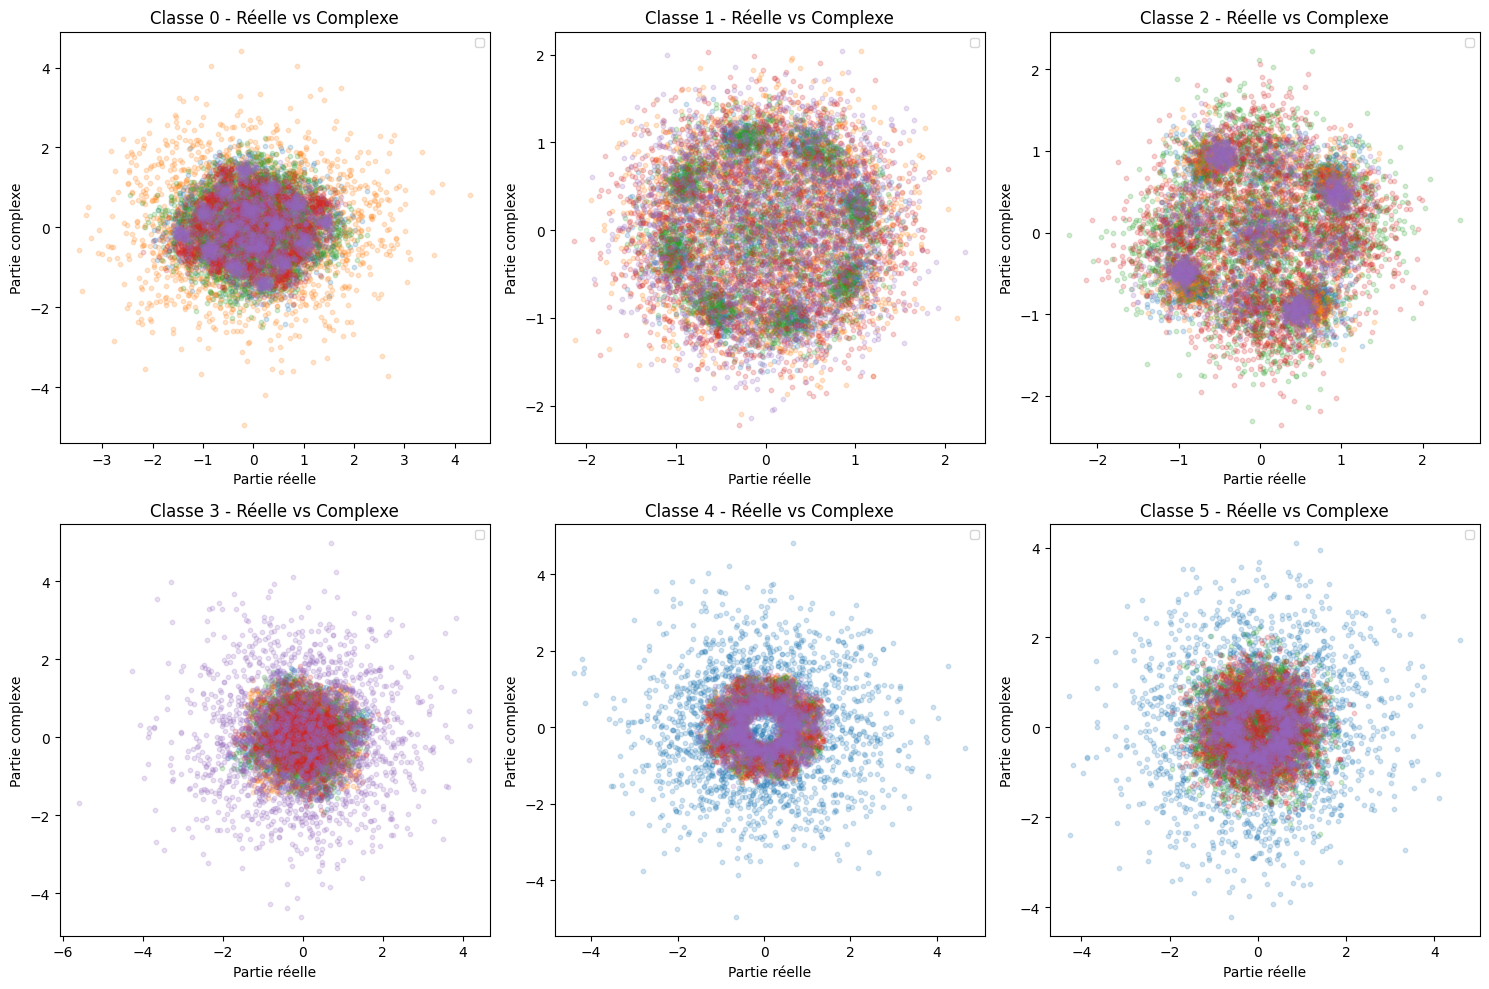

In [6]:
# Appel de la fonction avec les données
utils.tracer_reelle_vs_complexe_par_classe(signals, labels_id, k=5)


Comme on peut le constater sur ces graphiques, les données présentent certaines structures intéressantes. 
Cependant, ces structures semblent trop complexes pour permettre l'élaboration d'un modèle simple 
basé uniquement sur les relations entre les variables observées.

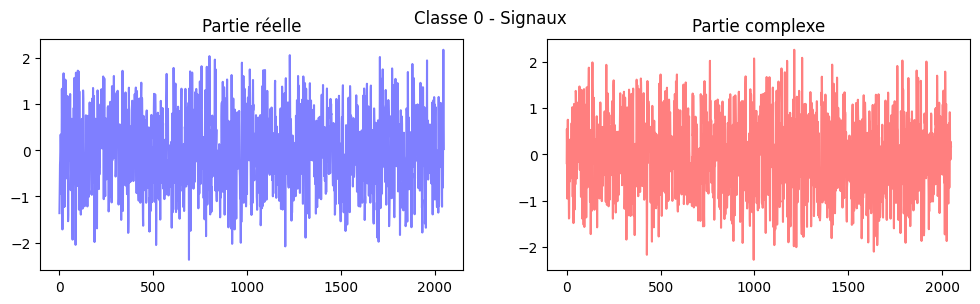

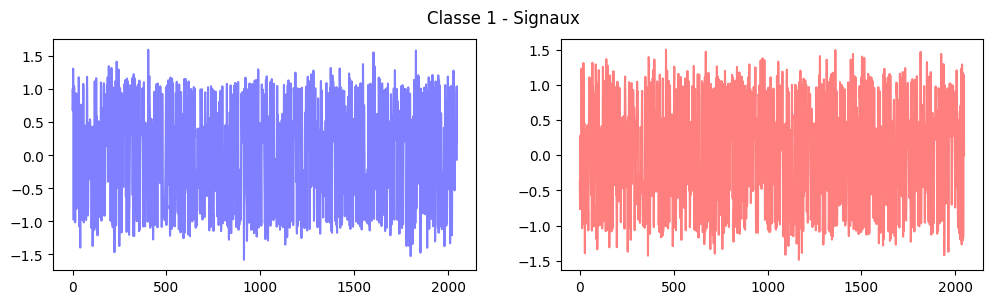

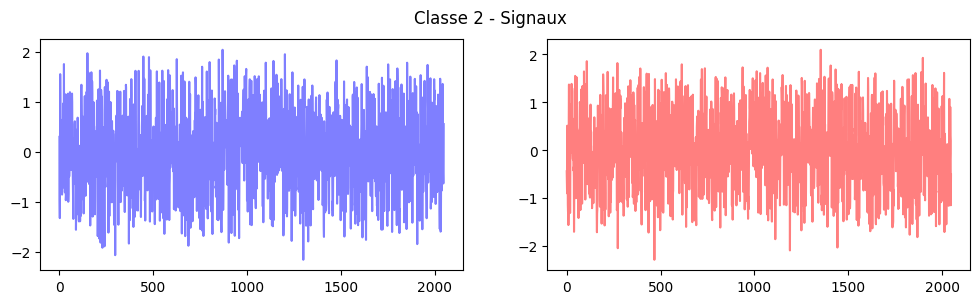

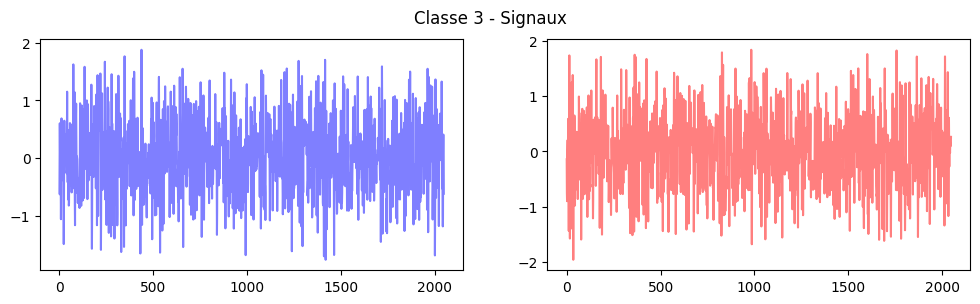

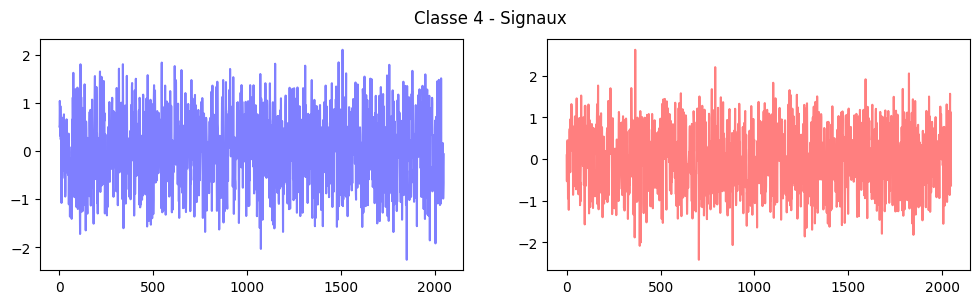

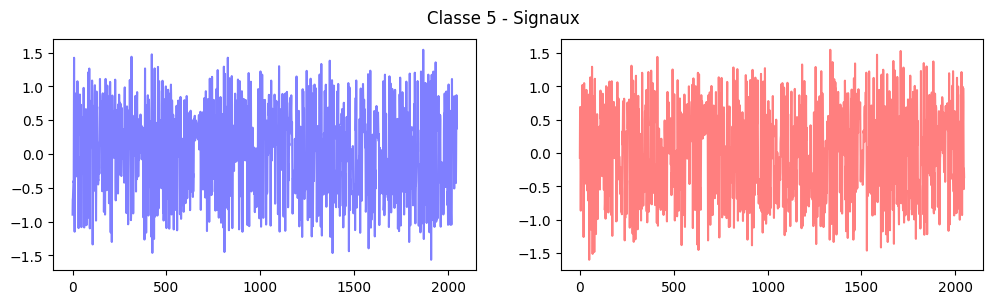

In [7]:
# Appel de la fonction avec les données
utils.tracer_signaux_par_classe(signals, labels_id, k=1)

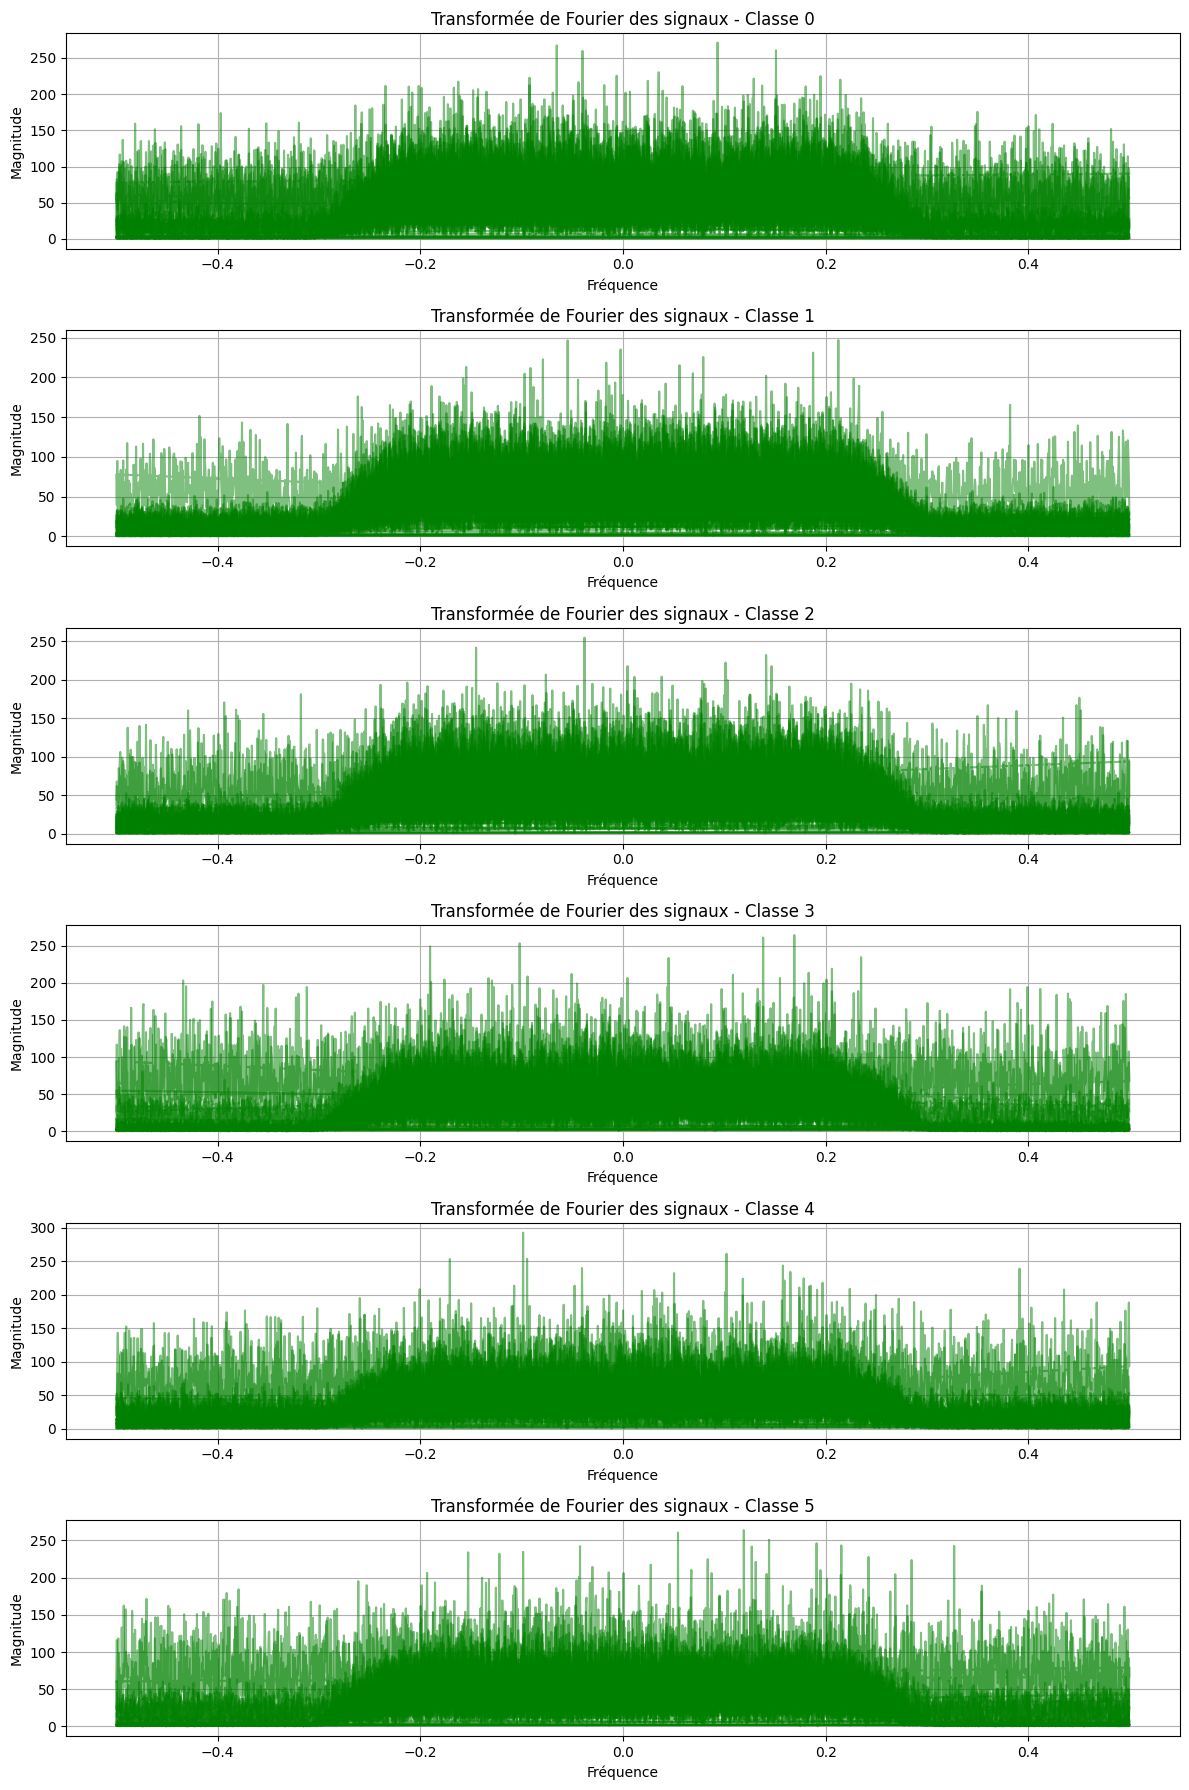

In [8]:
# Appel de la fonction avec les données
utils.tracer_fourier_signaux(signals, labels_id, k=20)

## **Chargement des données en Pytorch**

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch. 
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
 
- un **Dataset** qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
- un **Dataloader** qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones 
    
Un dataset prend la forme 
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici 

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [9]:
from utils import MyDataset

In [10]:
data_path = 'samples.hdf5'
dataset = MyDataset(data_path)

sample_signal, _, sample_label = dataset[0]
print("Signal shape:", sample_signal.shape)
print("Signal type:", type(sample_signal))
print("Label:", sample_label)
print("Label type:", type(sample_label))

Signal shape: (2, 2048)
Signal type: <class 'numpy.ndarray'>
Label: 2
Label type: <class 'numpy.int8'>


Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset. 
La cellule suivante donne un exemple d'utilisation

In [11]:
dataloader = DataLoader(dataset, 
                        batch_size=10, 
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size 

In [12]:
for signal, _, label in dataloader:
    print(signal.shape, label.shape)
    break

torch.Size([10, 2, 2048]) torch.Size([10])


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier). 

Ce modèle doit comporter moins de 10000 paramètres libres. 

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées (test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point).

In [13]:
from utils import DumbModel


In [14]:
B = 8     # batch size
C = 2     # dimension de la série
T = 2048  # taille de la série temporelle
n_classes = 6 # Nombre de classes

model = DumbModel(T, n_classes, out_channels=4, kernel_size=20, stride=10)

input_data = torch.randn(B, C, T)  # (8, 2, 2048)
output = model(input_data)

print("Forme de l'entrée :", input_data.shape)
print("Forme de la sortie :", output.shape)
print(output)

Forme de l'entrée : torch.Size([8, 2, 2048])
Forme de la sortie : torch.Size([8, 6])
tensor([[-2.0712, -1.7600, -2.2297, -1.5329, -1.5205, -1.8334],
        [-1.7277, -1.6209, -2.0285, -1.8072, -1.6427, -1.9990],
        [-1.6091, -1.6877, -2.4417, -1.8897, -1.4539, -1.9434],
        [-2.0510, -1.6838, -2.1692, -1.5570, -1.8382, -1.6015],
        [-1.2815, -1.5599, -1.8730, -2.2278, -2.1123, -2.0415],
        [-1.7417, -1.8320, -1.8147, -1.5972, -1.7594, -2.0621],
        [-1.7092, -1.8250, -1.8607, -1.8027, -1.8090, -1.7513],
        [-2.0172, -1.7232, -1.9212, -2.0761, -1.5962, -1.5420]],
       grad_fn=<LogSoftmaxBackward0>)


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante : 

Nombre de paramètres: On a une couche de convolution qui a un nombre de paramètres:


In [15]:
input_size = 2048
n_classes = 6
kernel_size = 20
out_channels = 4 # = dim out
dim_in = 2
stride = 10
n_params_linear = out_channels* (((input_size - kernel_size) // stride) // 2  + (stride % 2)) *n_classes+ n_classes
n_params_conv = kernel_size* dim_in * out_channels + out_channels
print(n_params_linear+n_params_conv)

2594


In [16]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

print(count_n_param(model))

2594


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à 
- charger les données 
- les batcher 
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires 

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs. 

In [17]:
train_dataset = MyDataset('train.hdf5')
dataloader_train = DataLoader(train_dataset,
                        batch_size=256,
                        shuffle=True
                       )

valid_dataset = MyDataset('validation.hdf5')
dataloader_valid = DataLoader(valid_dataset,
                                batch_size=128,
                                shuffle=False
                                 )

test_dataset = MyDataset('test.hdf5')
dataloader_test = DataLoader(test_dataset,
                                batch_size=32,
                                shuffle=False
                                 )

In [18]:
from utils import SimpleModelTrainer

Le `SimpleModelTrainer` permet d'entraîner un modèle de réseau neuronal en utilisant les fonctions suivantes :

1. `.fit()`
Cette fonction entraîne le modèle sur un ensemble de données (`dataloader`) et effectue les opérations suivantes :
- Entraîne le modèle sur les données d'entraînement.
- Teste le modèle sur l'ensemble de validation toutes les `critic_test` epochs.
- Si aucune amélioration n'est observée sur l'ensemble de validation pendant un nombre d'epochs défini par `patience`, l'entraînement s'arrête.
- Charge ensuite le modèle qui a obtenu les meilleures performances sur l'ensemble de validation.

2.  `.plot_loss()`
Cette fonction affiche un graphique de la perte moyenne (loss) au fil des epochs pendant l'entraînement, en comparant l'ensemble de données d'entraînement et de validation.

3.  `._test()`
Cette fonction permet de tester le modèle sur un ensemble de données donné et de renvoyer les résultats (prédictions, labels et pertes).

4.  `.full_proc()`
La fonction `full_proc()` résume l'ensemble du processus d'entraînement et d'évaluation :
- Entraîne le modèle via `.fit()`.
- Affiche la courbe de perte avec `.plot_loss()`.
- Teste le modèle sur l'ensemble de test et renvoie l'accuracy du modèle sur cet ensemble.

In [19]:
model = DumbModel() 

trainer = SimpleModelTrainer(model, device=device)

trainer.fit(dataloader=dataloader_train, valid_loader=dataloader_valid, n_epochs=100, critic_test=5, lr=1e-4)

Epoch 100/100 - Train Loss: 1.0605 - Test Loss: 1.2623: 100%|██████████| 100/100 [09:25<00:00,  5.66s/it]


Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction 
```python
modele = torch.load(...) 
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement. 
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps (facultatif), si vous le souhaitez vous pouvez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch. 

In [20]:
dic_results = {}

Epoch 0/100 - Train Loss: 0.0000 - Test Loss: 0.0000:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 77/100 - Train Loss: 1.0564 - Test Loss: 1.2723:  77%|███████▋  | 77/100 [10:15<03:03,  8.00s/it]


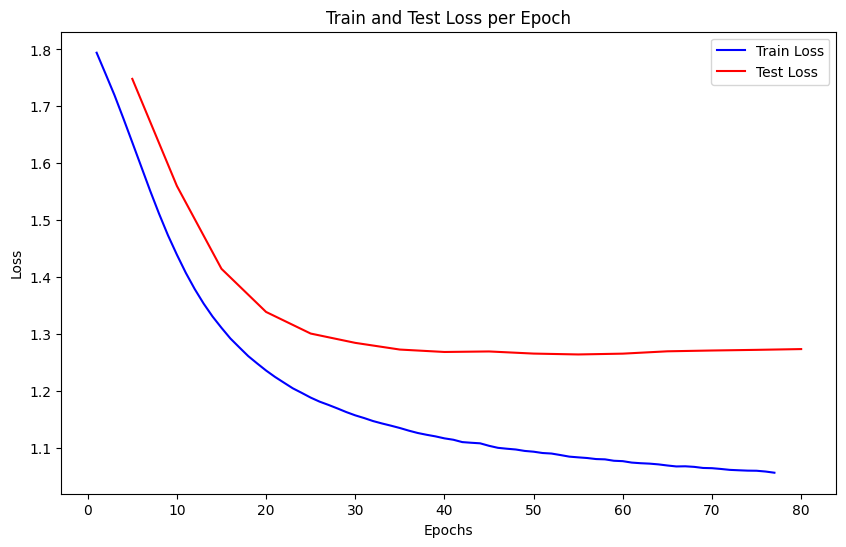

100%|██████████| 313/313 [00:01<00:00, 174.13it/s]


              precision    recall  f1-score   support

           0       0.36      0.36      0.36      1697
           1       0.33      0.38      0.35      1650
           2       0.32      0.28      0.30      1653
           3       0.32      0.34      0.33      1653
           4       0.33      0.35      0.34      1684
           5       0.32      0.28      0.30      1663

    accuracy                           0.33     10000
   macro avg       0.33      0.33      0.33     10000
weighted avg       0.33      0.33      0.33     10000



In [22]:
dumbmodel = DumbModel()

trainer = SimpleModelTrainer(dumbmodel, device=device)

dic_results["DumbModel"] = trainer.full_proc(train_dataloader=dataloader_train,
                                          valid_dataloader=dataloader_valid, test_dataloader=dataloader_test,
                                          n_epochs=100,
                                          critic_test=5,
                                          lr=1e-4, model_path="DumbModel.pth")

## Synthèse de résultats 

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec. 

In [23]:
from utils import Model2ConvNonLinearFC

In [ ]:
model2 = Model2ConvNonLinearFC()

trainer = SimpleModelTrainer(model2, device=device)

dic_results["model2"] = trainer.full_proc(train_dataloader=dataloader_train,
                                          valid_dataloader=dataloader_valid, test_dataloader=dataloader_test,
                                          n_epochs=100,
                                          critic_test=5,
                                          lr=1e-4, model_path="model2.pth")

In [ ]:
print(f"Accuracy model 2: {dic_results["Model2Conv"]:.4f}")


Dans ce modèle, on constate une amélioration des performances simplement en enchaînant deux couches de convolutions successives. Chaque couche de convolution permet de mieux capturer des caractéristiques locales du signal en augmentant progressivement la profondeur des filtres. L'ajout de plusieurs couches de convolutions permet d'élargir le champ réceptif des neurones à la fin de l'architecture. Cela signifie qu'un neurone dans les couches profondes de l'architecture va tenir compte d'une portion de plus en plus large des données d'entrée, ce qui permet d'extraire des motifs plus complexes et plus globaux du signal.

L'utilisation de deux couches de convolutions plutôt que d'une seule est particulièrement avantageuse pour apprendre des représentations hiérarchiques des données. La première couche capture des motifs simples (comme des bords ou des motifs répétitifs) et la deuxième couche affine cette extraction en combinant ces motifs simples en éléments plus complexes. De plus, cette stratégie permet de mieux se préparer à des variations complexes dans les données.

Le modèle bénéficie aussi de la non-linéarité introduite dans la couche fully connected. Plutôt que de se limiter à une simple sortie linéaire après la couche FC, l'ajout d'une activation ReLU avant la sortie permet de mieux modéliser des relations non linéaires complexes entre les caractéristiques extraites, ce qui peut être crucial pour des tâches de classification difficiles.

En somme, il semble qu'un grand champ réceptif soit un atout pour ce genre de tâche, car il permet au modèle de capturer des dépendances à plus longue portée dans les données. L'enchaînement des couches de convolutions permet de renforcer cette capacité à modéliser des patterns complexes et d'améliorer ainsi les performances du modèle.

## **Modèles plus complexes**

In [ ]:
from utils import ModelDilatedConvLSTM
from utils import UNet1D
from utils import RNNModel

Détails de l'architecture :

1. **Convolutions dilatées** :
Les convolutions dilatées permettent d'augmenter le champ réceptif sans augmenter le nombre de paramètres ni la taille des noyaux. Elles sont particulièrement efficaces pour capter des dépendances à grande échelle dans des séquences longues, tout en conservant des détails locaux.  
Dans ce modèle, la première convolution est dilatée avec un facteur de 2 et la deuxième avec un facteur de 4. Cela permet de capter des motifs à différentes échelles.

2. **LSTM** :
Un LSTM à deux couches est utilisé après les convolutions dilatées pour capturer des dépendances temporelles à long terme.

3. **Couche fully connected avec activation ReLU** :
Une couche FC avec 128 neurones est suivie d'une activation ReLU avant de prédire les classes avec un LogSoftmax pour une classification multi-classes.

In [ ]:
model_dilated_conv_lstm = ModelDilatedConvLSTM()

dic_results["model_dilated"] = trainer.full_proc(train_dataloader=dataloader_train,
                                          valid_dataloader=dataloader_valid, test_dataloader=dataloader_test,
                                          n_epochs=300,
                                          critic_test=5,
                                          lr=1e-4, model_path="Modeldilated.pth")

In [ ]:
unet_model = UNet1D()

dic_results["unet1d"] = trainer.full_proc(train_dataloader=dataloader_train,
                                          valid_dataloader=dataloader_valid, test_dataloader=dataloader_test,
                                          n_epochs=300,
                                          critic_test=5,
                                          lr=1e-4, model_path="unet1d.pth")

In [ ]:
rnn_model = RNNModel()

dic_results["rnn_model"] = trainer.full_proc(train_dataloader=dataloader_train,
                                          valid_dataloader=dataloader_valid, test_dataloader=dataloader_test,
                                          n_epochs=300,
                                          critic_test=5,
                                          lr=1e-4, model_path="rnn_model.pth")